# Analyzing online Blood Bowl matches using Python: API scraping, pandas and plotnine

When I was a teenager, back in 1994, I bought the Blood Bowl strategy boardgame. Its like chess, but instead of two medieval kingdoms fighting, the game is about fantasy football, say Tolkien meets rugby. Already back then, the game appealed to me because it combined the Warhammer playing pieces I liked so much (e.g. models of Orcs, Elves, Dwarves etc) with a game that had simple rules (compared to the main wargaming systems at the time, Warhammer Fantasy Battle, and Warhammer 40K), but resulted in complex gameplay. Blood bowl requires a lot of skill to play well, with complex strategic decision making in the face of uncertainty (heavy dice rolling involved). Then, after painting half of the figures, I moved on to new exciting things. But throughout the years, this was the only game I kept moving to new places etc.
To my surprise, when I regained interest a few years ago, an international gaming community had formed around the game, with a players' association, the NAF, with thousands of members, a World championship every two years, and with new editions and models being released on a regular basis.

So last year, I finally decided to pick it up again, painted the remaining figures (see photo below for the end result) and started my search for actual opponents to play against. I found a local community in a city nearby, and I am having a great time learning the strategic finesses of the all the teams, painting new miniatures, and looking forward to my first tabletop tournament, to be held in a few months if the dreaded Nurgle rot (aka Corona) allows it.

Of course, you want to see a photo of my painted team right? (It appears i am not the only one who has this urge, there are special Reddit and Facebook groups where you can showcase your painted Blood Bowl team).

Now, Another amazing thing happened while I was away: Blood Bowl went online, with people playing games using a (free!) client-server system called FUMBBL, that came into existence at around 2003. As with all sports (and yes, Blood Bowl is a sport, like Chess and Go), statistics are not far away. The website (https://fumbbl.com) is one big pile of data. From coach pages, with their teams, to team rosters, with players, and match histories. It's all there. And what's more: the site creator Christer Kaivo-oja, from Sweden, has made an API that allows us to easily fetch data. The full documentation of the API can be found at (https://fumbbl.com/apidoc/). 

The goal of this blog post is to use Python API scraping to fetch the data, and to use the pandas and plotnine packages to analyse and visualise the data.

PM Questions we answer (races, ruleset) and why

# Using Python to fetch and analyze data

Our goal is to fetch all match data for one of my teams, the **Hillywood Hellraiser 2.0**. 

Lets start with seeing what is available at the coach level. We use the Python **Requests** library to make the API call over HTTPS and obtain the response from the FUMBLL server.

In [1]:
import requests
import random
import pandas as pd
import time

response = requests.get("https://fumbbl.com/api/coach/teams/gsverhoeven")
#response = requests.get("https://fumbbl.com/api/coach/teams/Erik") plays in BB2020 competitive division

In [2]:
response.json()

{'id': 255851,
 'name': 'gsverhoeven',
 'teams': [{'id': 1003452,
   'coachId': 255851,
   'name': 'Hillywood Hellraisers',
   'rosterId': 50,
   'race': 'Human',
   'teamValue': 1090000,
   'canLfg': 'Yes',
   'isLfg': 'Yes',
   'games': '3',
   'divisionId': 1,
   'division': 'Ranked',
   'leagueId': 0,
   'league': None,
   'status': 'Retired',
   'raceLogos': [{'size': 32, 'logo': 486290},
    {'size': 48, 'logo': 486291},
    {'size': 64, 'logo': 486292},
    {'size': 96, 'logo': 486293},
    {'size': 128, 'logo': 486294},
    {'size': 192, 'logo': 486295}]},
  {'id': 1035833,
   'coachId': 255851,
   'name': 'Pharaoh Munchers',
   'rosterId': 51,
   'race': 'Tomb Kings',
   'teamValue': 960000,
   'canLfg': 'Yes',
   'isLfg': 'No',
   'games': '0',
   'divisionId': 1,
   'division': 'Ranked',
   'leagueId': 0,
   'league': None,
   'status': 'Active',
   'raceLogos': [{'size': 32, 'logo': 486296},
    {'size': 48, 'logo': 486297},
    {'size': 64, 'logo': 486298},
    {'size': 96

Let's have a close look at the data structure here.
We have a list of key-value pairs. 
Some keys contain simple values, such as `name`, 

In [3]:
response.json()['name']

'gsverhoeven'

but some return as value a new list of key-value pairs, such as `teams`.
Actually this is a list of lists of key-value pairs, since we have a separate list for each team.
Even the list of a single team contains new structure, for example under the key `raceLogos`.

In [4]:
response.json()['teams'][2]['raceLogos']

[{'size': 32, 'logo': 486290},
 {'size': 48, 'logo': 486291},
 {'size': 64, 'logo': 486292},
 {'size': 96, 'logo': 486293},
 {'size': 128, 'logo': 486294},
 {'size': 192, 'logo': 486295}]

In [5]:
response.json()['teams'][2]['name']

'Blackbox Bastards'

# Data structure

Now what would be a logical data structure to analyse race strength, eventually adjusting for coach strength?

The most straightforward level to analyze coach strength is to look at match outcomes.
Furthermore, we expect coach strength to change over time, likely to increase, but it could also decrease when rules changes or the coach decides to focus less on winning and more on other goals such as having fun, or experimenting with tactics. So the time dimension is important as well.

For this we need a flat data frame with rows for each match, and columns for the various variables associated with each match.
These would include:

* Coach ids
* Races
* Team ids
* Date of the match
* Outcome (Touchdowns of both teams)

With this basic structure, we can add as many match related variables in the future, keeping the basic structure (each row is a match) unchanged.



# Team list by coach

Lets start with a list of all teams from a single coach, with team names and ids.

In [6]:
df_teams = pd.DataFrame(columns=['coach_id', 'team_id', 'team_name'])

for i in range(len(response.json()['teams'])):
    coach_id = response.json()['teams'][i]['coachId'] 
    team_id = response.json()['teams'][i]['id']
    team_name = response.json()['teams'][i]['name']
    df_teams.loc[i] = [coach_id, team_id, team_name]


print(df_teams)

  coach_id  team_id                     team_name
0   255851  1003452         Hillywood Hellraisers
1   255851  1035833              Pharaoh Munchers
2   255851  1035835             Blackbox Bastards
3   255851  1036599          Seven cities of Gold
4   255851  1038960     Hillywood Hellraisers 2.0
5   255851  1050267         Gooische Heidebeukers
6   255851  1052980  [2020] Hillywood Hellraisers
7   255851  1053065            [2020] Grrrl power


# Merge match data to the coach_team table

Now that we have a coach / team table, we can add match outcome data to it. For this, we need another API call.

In [7]:
response2 = requests.get("https://fumbbl.com/api/team/matches/1038960")
response2.json()

[{'id': 4334858,
  'replayId': 1473582,
  'tournamentId': 0,
  'date': '2021-10-11',
  'time': '23:29:14',
  'gate': 27000,
  'hasComments': 'false',
  'team1': {'id': 1032032,
   'name': "Short 'n' Curlies 3",
   'score': 3,
   'casualties': {'bh': 2, 'si': 1, 'rip': 0},
   'fanfactor': 1,
   'teamValue': '1260k',
   'coach': {'id': 246766, 'name': 'bbhdnp'},
   'winnings': 80000,
   'gate': 14000,
   'tournamentWeight': '1330k'},
  'team2': {'id': 1038960,
   'name': 'Hillywood Hellraisers 2.0',
   'score': 0,
   'casualties': {'bh': 0, 'si': 0, 'rip': 0},
   'fanfactor': 0,
   'teamValue': '1110k',
   'coach': {'id': 255851, 'name': 'gsverhoeven'},
   'winnings': 10000,
   'gate': 13000,
   'tournamentWeight': '1160k'}},
 {'id': 4326781,
  'replayId': 1464328,
  'tournamentId': 0,
  'date': '2021-09-13',
  'time': '00:03:53',
  'gate': 19000,
  'hasComments': 'false',
  'team1': {'id': 1038960,
   'name': 'Hillywood Hellraisers 2.0',
   'score': 2,
   'casualties': {'bh': 1, 'si': 0

In [8]:
df_matches = pd.DataFrame(columns=['match_id', 'match_date', 'match_time',  'team1_id', 'team2_id', 'team1_score', 'team2_score'])

player_teams = df_teams['team_id']
row_count = 0

#print(player_teams)
for t in range(len(player_teams)):
    api_string = "https://fumbbl.com/api/team/matches/" + str(player_teams[t])
    #print(api_string)
    time.sleep(0.4)
    matches = requests.get(api_string)
    matches = matches.json()
    for m in range(len(matches)):
        match_id = matches[m]['id']
        match_date = matches[m]['date']
        match_time = matches[m]['time']
        team1_id = matches[m]['team1']['id']
        team2_id = matches[m]['team2']['id']
        team1_score = matches[m]['team1']['score']
        team2_score = matches[m]['team2']['score']   
        print(match_id)     
        df_matches.loc[row_count] = [match_id, match_date, match_time, team1_id, team2_id, team1_score, team2_score]
        row_count += 1
    

df_matches

4314794
4270093
4248074
4316193
4334858
4326781
4324190
4321824
4338772
4337749


,match_id,match_date,match_time,team1_id,team2_id,team1_score,team2_score
0,4314794,2021-07-01,22:18:41,1003452,1035627,0,1
1,4270093,2021-01-17,21:21:06,893084,1003452,2,1
2,4248074,2020-11-13,22:18:01,1007609,1003452,2,1
3,4316193,2021-07-10,22:51:01,1036595,1035835,2,1
4,4334858,2021-10-11,23:29:14,1032032,1038960,3,0
5,4326781,2021-09-13,00:03:53,1038960,1042436,2,1
6,4324190,2021-09-01,22:39:00,1038960,1040226,0,3
7,4321824,2021-08-16,23:42:39,1038376,1038960,2,2
8,4338772,2021-10-26,22:36:27,1050267,1049642,2,1
9,4337749,2021-10-22,22:14:35,1049822,1050267,2,0


# Getting the race and ruleset of each team

Let grab for all teams in `df_matches` the team **race** and **ruleset**.
The ruleset is important, because races can get **nerfed** (made weaker) or **buffed** (made stronger) when new versions of the ruleset are released.
These changes are common in any gaming community, in an attempt to achieve more balance in the game.

**PM** write a function that takes as argument a list of team_ids, and returns a dataframe with ruleset/roster info.

In [9]:
df_teams = pd.DataFrame(columns=['team_id', 'ruleset', 'roster_id', 'race_name',  'games_played'])

team_ids = list(df_matches['team1_id']) + list(df_matches['team2_id'])

for t in range(len(team_ids)):    
    api_string = "https://fumbbl.com/api/team/get/" + str(team_ids[t])
    print(api_string)
    time.sleep(0.3)
    team = requests.get(api_string)
    team = team.json()
    team_id = team['id']
    ruleset = team['ruleset']
    roster_id = team['roster']['id']
    race_name = team['roster']['name']
    games_played = team['record']['games']
    df_teams.loc[t] = [team_id, ruleset, roster_id, race_name, games_played]

df_teams

https://fumbbl.com/api/team/get/1003452
https://fumbbl.com/api/team/get/893084
https://fumbbl.com/api/team/get/1007609
https://fumbbl.com/api/team/get/1036595
https://fumbbl.com/api/team/get/1032032
https://fumbbl.com/api/team/get/1038960
https://fumbbl.com/api/team/get/1038960
https://fumbbl.com/api/team/get/1038376
https://fumbbl.com/api/team/get/1050267
https://fumbbl.com/api/team/get/1049822
https://fumbbl.com/api/team/get/1035627
https://fumbbl.com/api/team/get/1003452
https://fumbbl.com/api/team/get/1003452
https://fumbbl.com/api/team/get/1035835
https://fumbbl.com/api/team/get/1038960
https://fumbbl.com/api/team/get/1042436
https://fumbbl.com/api/team/get/1040226
https://fumbbl.com/api/team/get/1038960
https://fumbbl.com/api/team/get/1049642
https://fumbbl.com/api/team/get/1050267


,team_id,ruleset,roster_id,race_name,games_played
0,1003452,1,50,Human,3
1,893084,1,50,Human,6
2,1007609,1,44,Dark Elf,9
3,1036595,1,46,Elven Union,4
4,1032032,1,45,Dwarf,6
5,1038960,1,50,Human,4
6,1038960,1,50,Human,4
7,1038376,1,50,Human,6
8,1050267,2290,4974,Orc,2
9,1049822,2290,4964,Human,3


# Step 1: Getting the match data

So we are mostly intested in the current ruleset, this is `BB2020`. This ruleset became available last month, and some 5000 games have been played since.
We also want to compare with the previous ruleset, where we have much more data available. How far do we go back? 
Lets start with matches played during the last year. So starting from september 1st, 2020, up to oktober 1st, 2021. 
This way, we have roughly 12 months of `BB2016` ruleset matches, and one month of `BB2020` matches.

Easiest way to fetch them appears to just loop over `match_id`. The most recent match was 4.334.456, and since rougly 100.000 matches are played each year, we can fiddle about and we find match 4.226.550 played on september 1st, 2020.  So that means we need to collect some 110K matches. 
We do not want to overload the server, so let's make two API requests per second. To collect 110K matches, we will need 110000*0.5/3600 = 15 hours.
We can manage this by two nightly runs of 8 hours.

In [10]:
110000*0.5/3600

15.277777777777779

In [11]:
import time
import numpy as np


df_matches2 = pd.DataFrame(columns=['match_id', 'match_date', 'match_time',  
    'team1_id', 'team1_coach_id', 'team1_roster_id', 'team1_race_name', 
    'team2_id', 'team2_coach_id', 'team2_roster_id', 'team2_race_name', 
    'team1_score', 'team2_score'])

target = 'data/df_matches_' + time.strftime("%Y%m%d_%H%M%S") + '.h5'
print(target)

end_match = 4339204	
begin_match = 4216257 
n_matches = end_match - begin_match
full_run = 0
print(n_matches)

if(full_run):
    for i in range(n_matches):
        api_string = "https://fumbbl.com/api/match/get/" + str(end_match - i)
        #print(api_string)
        #print(".", end = '')
        wait_time = (random.uniform(0.5, 1) + 0.25)/2
        time.sleep(wait_time)
        match = requests.get(api_string)
        match = match.json()
        if match: # fix for matches that do not exist
            match_id = match['id']
            match_date = match['date']
            match_time = match['time']
            team1_id = match['team1']['id']
            team2_id = match['team2']['id']
            team1_score = match['team1']['score']
            team2_score = match['team2']['score']  
            team1_roster_id = match['team1']['roster']['id']
            team1_race_name = match['team1']['roster']['name'] 
            team1_coach_id = match['team1']['coach']['id']
            team2_coach_id = match['team2']['coach']['id']
            team2_roster_id = match['team2']['roster']['id']
            team2_race_name = match['team2']['roster']['name'] 
            #print(match_id)     
            df_matches2.loc[i] = [match_id, match_date, match_time, 
                team1_id, team1_coach_id, team1_roster_id, team1_race_name, 
                team2_id, team2_coach_id, team2_roster_id, team2_race_name, 
                team1_score, team2_score]
        else:
            # empty data for this match, create empty row
            match_id = int(end_match - i)
            df_matches2.loc[i] = [np.NaN, np.NaN, np.NaN, 
            np.NaN,np.NaN,np.NaN,np.NaN,
            np.NaN,np.NaN,np.NaN,np.NaN,
            np.NaN,np.NaN]
            df_matches2.loc[i]['match_id'] = int(match_id)
        if i % 100 == 0: 
            # write tmp data as hdf5 file
            print(i, end='')
            print(".", end='')
            df_matches2.to_hdf(target, key='df_matches2', mode='w')

    # write data as hdf5 file
    df_matches2.to_hdf(target, key='df_matches2', mode='w')
else:
    # read from hdf5 file
    #df_matches2 = pd.read_hdf('data/df_matches_20211010_232026.h5')
    #df_matches3 = pd.read_hdf('data/df_matches_20211015_085420.h5')
    #df_matches4 = pd.read_hdf('data/df_matches_20211015_221439.h5')
    #df_matches5 = pd.read_hdf('data/df_matches_20211028_182012.h5')
    #df_matches_final = df_matches2.append(df_matches3).append(df_matches4).append(df_matches5)
    #df_matches_final.to_hdf(target, key='df_matches2', mode='w')
    df_matches_final = pd.read_hdf('data/df_matches_20211102_083311.h5')
    
#

data/df_matches_20211103_223538.h5
122947


In [12]:
# Fix the datatypes of the columns
#df_matches2 = df_matches2.astype(dtype= {"match_id":"int64",
 #       "team1_id":"int64","team2_id":"int64"})

#df_matches2['match_date'] = pd.to_datetime(df_matches2.match_date + ' ' + df_matches2.match_time)

#df_matches2.shape # 10K
#df_matches3.shape # 58201
#df_matches4.shape # 50K
df_matches_final['match_id'].min()
#df_matches_final['match_id'].max()


4216257

In [13]:
# convert object dtype columns to proper dtypes
df_matches_final['match_date'] = pd.to_datetime(df_matches_final.match_date) 
df_matches_final['match_id'] = pd.to_numeric(df_matches_final.match_id) 
df_matches_final['team1_id'] = pd.to_numeric(df_matches_final.team1_id) 
df_matches_final['team1_coach_id'] = pd.to_numeric(df_matches_final.team1_coach_id) 
df_matches_final['team1_roster_id'] = pd.to_numeric(df_matches_final.team1_roster_id) 
df_matches_final['team2_id'] = pd.to_numeric(df_matches_final.team2_id) 
df_matches_final['team2_coach_id'] = pd.to_numeric(df_matches_final.team2_coach_id) 
df_matches_final['team2_roster_id'] = pd.to_numeric(df_matches_final.team2_roster_id) 
df_matches_final['team1_score'] = pd.to_numeric(df_matches_final.team1_score) 
df_matches_final['team2_score'] = pd.to_numeric(df_matches_final.team2_score) 

In [14]:
df_matches_final.dtypes

match_id                    int64
match_date         datetime64[ns]
match_time                 object
team1_id                  float64
team1_coach_id            float64
team1_roster_id           float64
team1_race_name            object
team2_id                  float64
team2_coach_id            float64
team2_roster_id           float64
team2_race_name            object
team1_score               float64
team2_score               float64
dtype: object

In [15]:
# 123K matches
df_matches_final

,match_id,match_date,match_time,team1_id,team1_coach_id,team1_roster_id,team1_race_name,team2_id,team2_coach_id,team2_roster_id,team2_race_name,team1_score,team2_score
0,4334456,2021-10-10,16:35:03,1049648.0,226125.0,4965.0,Imperial Nobility,1048983.0,254711.0,5141.0,Amazon,0.0,2.0
1,4334455,2021-10-10,16:34:05,1048235.0,89561.0,4979.0,Wood Elf,1045145.0,239543.0,4959.0,Dark Elf,1.0,2.0
2,4334454,2021-10-10,16:32:47,1049309.0,67411.0,4959.0,Dark Elf,1049010.0,250569.0,4958.0,Chaos Renegade,1.0,1.0
3,4334453,2021-10-10,16:28:43,1042469.0,245804.0,4956.0,Black Orc,1047602.0,259236.0,5144.0,Norse,2.0,0.0
4,4334452,2021-10-10,16:20:00,1049094.0,131119.0,5141.0,Amazon,1048512.0,259759.0,4966.0,Lizardmen,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4743,4334461,2021-10-10,17:09:33,1049082.0,11376.0,4975.0,Shambling Undead,1048469.0,39409.0,4969.0,Necromantic Horror,1.0,1.0
4744,4334460,2021-10-10,17:07:53,1043941.0,258635.0,5144.0,Norse,1046586.0,255796.0,4964.0,Human,0.0,1.0
4745,4334459,2021-10-10,17:03:18,1049216.0,254700.0,4978.0,Underworld Denizens,1046895.0,124717.0,4966.0,Lizardmen,1.0,2.0
4746,4334458,2021-10-10,16:54:07,912871.0,242050.0,72.0,Simyin,963369.0,250997.0,56.0,Ogre,2.0,0.0


# First plots: race popularity

Which races are the most popular on FUMBLL in the last year?

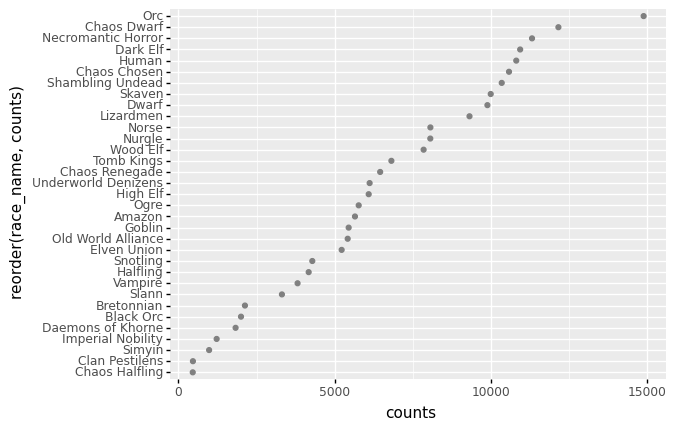

<ggplot: (8738987182733)>

In [16]:
import plotnine as p9

team1_races = df_matches_final[['match_id', 'team1_race_name']]
team2_races = df_matches_final[['match_id', 'team2_race_name']]

# make column names equal
team1_races.columns = team2_races.columns = ['match_id', 'race_name']

# row bind the two dataframes
df_races = pd.concat([team1_races, team2_races])

# aggregate
res = (df_races
        .groupby(['race_name'])
        .size()
        .reset_index(name='counts')
        .sort_values(by=['counts'], ascending = False)
)

# filter (used below: FIX THIS)
top_races = res.loc[(res.counts > 400)]['race_name']

(p9.ggplot(data = res.loc[(res.counts > 400)], mapping = p9.aes(x = 'reorder(race_name, counts)', y = 'counts'))
    + p9.geom_point(colour = 'gray') 
    + p9.coord_flip())

# prepare for raw win rates by race

Mike Davies from the NAF calculates win rate by weighting each win as 1 point ,and each draw as 0.5 points.
Let's do the same here!

In [17]:
import numpy as np

# calculate match score difference
df_matches_final['team1_win'] = np.sign(df_matches_final['team1_score'] - df_matches_final['team2_score'])
df_matches_final['team2_win'] = np.sign(df_matches_final['team2_score'] - df_matches_final['team1_score'])

team1_wins = df_matches_final[['match_id', 'match_date', 'team1_id', 'team1_race_name', 'team1_win']].copy()

team2_wins = df_matches_final[['match_id', 'match_date',  'team2_id', 'team2_race_name', 'team2_win']].copy()


team1_wins.columns = team2_wins.columns = ['match_id', 'match_date', 'team_id', 'race_name', 'wins']
#team2_wins['wins'] = -1 * team2_wins['wins']

df_wins = pd.concat([team1_wins, team2_wins])

df_wins.loc[df_wins['wins'] == 0, 'wins'] = 0.5
df_wins.loc[df_wins['wins'] == -1, 'wins'] = 0

# convert to float
df_wins['wins'] = df_wins['wins'].astype(float)


In [18]:
df_wins

,match_id,match_date,team_id,race_name,wins
0,4334456,2021-10-10,1049648.0,Imperial Nobility,0.0
1,4334455,2021-10-10,1048235.0,Wood Elf,0.0
2,4334454,2021-10-10,1049309.0,Dark Elf,0.5
3,4334453,2021-10-10,1042469.0,Black Orc,1.0
4,4334452,2021-10-10,1049094.0,Amazon,0.0
...,...,...,...,...,...
4743,4334461,2021-10-10,1048469.0,Necromantic Horror,0.5
4744,4334460,2021-10-10,1046586.0,Human,1.0
4745,4334459,2021-10-10,1046895.0,Lizardmen,1.0
4746,4334458,2021-10-10,963369.0,Ogre,0.0


# Tidyverse-like data analysis with Pandas

Doing most of my day to day analysis in `R`, i am (by now) used to the tidyverse filosophy of breaking things apart in small steps, with each step on a separate line, and in order of execution. Luckily, the `Pandas` data analysis library allows us to do something similar, here it is called `method chaining`.
The idea is that a Pandas object has methods for all the small operations we want to perform, and the python language that allows chaining these methods together.

Here we demonstrate this by calculating average win percentage by race, and calling this result `perc_win`.

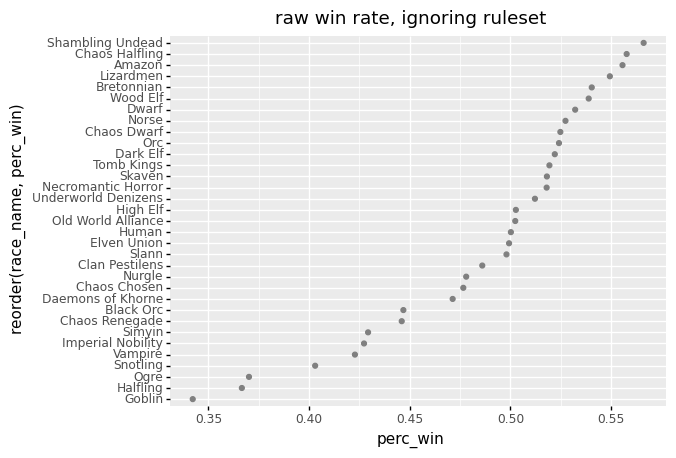

<ggplot: (-9223363297876111623)>

In [19]:
res = (df_wins
        .loc[df_wins['race_name'].isin(top_races.array)]
        .groupby('race_name')['wins']        
        .mean()
        .reset_index(name='perc_win'))


(p9.ggplot(data = res, mapping = p9.aes(x = 'reorder(race_name, perc_win)', y = 'perc_win'))
    + p9.geom_point(colour = 'gray') 
    + p9.coord_flip()
    + p9.ggtitle("raw win rate, ignoring ruleset"))

In [20]:
# check results (comparison with koadah)
(df_wins
    .query("race_name == 'Vampire' & match_id > 4329461")['wins']
    .value_counts())

0.0    217
1.0    109
0.5    101
Name: wins, dtype: int64

In [21]:
df_wins

,match_id,match_date,team_id,race_name,wins
0,4334456,2021-10-10,1049648.0,Imperial Nobility,0.0
1,4334455,2021-10-10,1048235.0,Wood Elf,0.0
2,4334454,2021-10-10,1049309.0,Dark Elf,0.5
3,4334453,2021-10-10,1042469.0,Black Orc,1.0
4,4334452,2021-10-10,1049094.0,Amazon,0.0
...,...,...,...,...,...
4743,4334461,2021-10-10,1048469.0,Necromantic Horror,0.5
4744,4334460,2021-10-10,1046586.0,Human,1.0
4745,4334459,2021-10-10,1046895.0,Lizardmen,1.0
4746,4334458,2021-10-10,963369.0,Ogre,0.0


# Step 2: Fetch team data (division, ruleset, roster, games_played) for all the teams in our matches dataset

530 min for 44K teams. This uses Python sets (minus operator gives elements of set that are different)

In [22]:

#df_teams = pd.read_hdf('data/df_teams_20211021_170210.h5')

# check for missing team_ids
#team_ids = set(df_teams.team_id)
#len(team_ids)
#all_team_ids = list(df_matches_final['team1_id'].dropna()) + list(df_matches_final['team2_id'].dropna())

# get unique values (nog steeds floats, grrr)
#all_team_ids = set(all_team_ids)

#len(all_team_ids) - len(team_ids)

#new_team_ids = all_team_ids - team_ids

In [23]:
df_teams = pd.DataFrame(columns=['team_id', 'division_id', 'division_name',  'league' ,
    'ruleset', 'roster_id', 'race_name',  'games_played'])

team_ids = list(df_matches_final['team1_id'].dropna()) + list(df_matches_final['team2_id'].dropna())


# get unique values (nog steeds floats, grrr)
team_ids = list(set(team_ids))

target = 'data/df_teams_' + time.strftime("%Y%m%d_%H%M%S") + '.h5'
print(target)

fullrun = 0
append = 0

#if append:
#    team_ids = list(new_team_ids)

if fullrun:
    print('fetching team data for ', len(team_ids), ' teams')
    for t in range(len(team_ids)):    
        api_string = "https://fumbbl.com/api/team/get/" + str(int(team_ids[t]))
        wait_time = (random.uniform(0.5, 1) + 0.25)/2 # avg time 0.5 s
        time.sleep(wait_time)
        team = requests.get(api_string)
        team = team.json()
        # grab fields
        team_id = team['id']
        division_id = team['divisionId']
        division_name = team['division']
        ruleset = team['ruleset']
        league = team['league']
        roster_id = team['roster']['id']
        race_name = team['roster']['name']
        games_played = team['record']['games']
        # add to dataframe
        df_teams.loc[t] = [team_id, division_id, division_name, league, ruleset, roster_id, race_name, games_played]
        if t % 100 == 0: 
            # write tmp data as hdf5 file
            print(t, end='')
            print(".", end='')
            df_teams.to_hdf(target, key='df_teams', mode='w')
    
    df_teams.to_hdf(target, key='df_teams', mode='w')
else:
    # read from hdf5 file
    df_teams = pd.read_hdf('data/df_teams_20211030_115137.h5')
    #df_teams2 = pd.read_hdf('data/df_teams_20211028_205719.h5')
    #df_teams = df_teams.append(df_teams2)
df_teams

data/df_teams_20211103_223545.h5


,team_id,division_id,division_name,league,ruleset,roster_id,race_name,games_played
0,1048576,5,League,0,6,56,Ogre,5
1,1048579,2,Competitive,0,4,5144,Norse,1
2,1048580,2,Competitive,0,4,5145,Tomb Kings,3
3,1048581,2,Competitive,0,4,4966,Lizardmen,15
4,1048583,2,Competitive,0,4,4958,Chaos Renegade,1
...,...,...,...,...,...,...,...,...
43742,1048569,2,Competitive,0,4,4956,Black Orc,1
43743,1048570,2,Competitive,0,4,4965,Imperial Nobility,2
43744,1048571,2,Competitive,0,4,5144,Norse,1
43745,1048572,2,Competitive,0,4,4970,Nurgle,4


# FUMBBL rulesets

FUMBBL allows coaches to create their own rulesets. For example, there is a so-called "Secret League" where coaches can play with "Ninja halflings", of with "Ethereal" spirits etc. Since we want the team strength for the official rulesets, we need to drop the other rulesets.

* Ruletset 4: BB2020 (correlated with Competitive division)
* Ruleset 1: BB2016 (correlated with Ranked division but also with Black box)
* Ruleset 6: League
* Ruleset 2228: NAF-BB2020
* Ruleset 303: United Open Rules (used by the Secret League, it allows teams like Ethereal)

**TODO: MOVE TO HUGO SOURCE , REFRAME TO API SCRAPING**

In [24]:
team_ids = list(set(team_ids))

len(team_ids)

43747

## Filter on most common rulesets

In [25]:
common_rulesets = (df_teams
    .groupby('ruleset')
    .agg( n_teams = ('ruleset', 'count')
    )
    .query('n_teams > 100')
    .reset_index()
)['ruleset']

(df_teams
    .groupby('ruleset')
    .agg( n_teams = ('ruleset', 'count')
    )
    .query('n_teams > 100')
    .reset_index()
)

,ruleset,n_teams
0,1,18403
1,2,745
2,4,4907
3,6,6850
4,7,112
5,91,151
6,303,2779
7,432,288
8,862,111
9,888,354


# Merging the match data with the team / ruleset data

For each match in the `df_wins` **DataFrame** we add the team-level information for `df_teams`.

In [26]:
df_wins.shape

(245898, 5)

In [27]:
df_wins2 = pd.merge(df_wins.drop('race_name', 1), df_teams, on='team_id', how='left')

df_wins2['roster_name'] = df_wins2['roster_id'].astype(str) + '_' + df_wins2['race_name']
# subset on BB2020 matches
#df_wins2 = df_wins2.query('ruleset == 4')
df_wins2.query("match_id == 4339204")

,match_id,match_date,team_id,wins,division_id,division_name,league,ruleset,roster_id,race_name,games_played,roster_name
118201,4339204,2021-10-28,1.04256e+06,0.0,2,Competitive,0,4,5142,Chaos Dwarf,6,5142_Chaos Dwarf
241150,4339204,2021-10-28,1.05175e+06,1.0,2,Competitive,0,4,4972,Old World Alliance,7,4972_Old World Alliance


In [28]:
df_wins2.match_id.max()


4339204

In [29]:
# write all rosters and rulesets with match counts to Excel file

res = (df_wins2
    .groupby(['race_name', 'roster_id', 'roster_name', 'ruleset'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_games = ('race_name', "count")
    )
    .reset_index()) # this adds the group by variable (now index) as a column

res

res.to_excel("codelist.xlsx")  



In [30]:
# check results
(df_wins2
    .query("race_name == 'Vampire' & ruleset == 4")['wins']
    .value_counts())

0.0    242
1.0    114
0.5    111
Name: wins, dtype: int64

# Visualizing Pandas timeseries with plotnine

So ... lets introduce the time series element here.
Can we visualize the gradual introduction of the new **BB2020** ruleset on FUMBBL?

Lets aggregate the data first by ruleset and week, and after that further distinguish the different races?


# Dataprep: Adding Week number to the dataframe

drop week 44 of 2021 because it is incomplete? we could use it for the win rate?

In [31]:
df_wins2['week_number'] = df_wins2['match_date'].dt.isocalendar().week
#df_wins2['week_number'] = df_wins2['week_number'].astype('Int64')
df_wins2['week_number'] = df_wins2['week_number'].fillna(0).astype(np.int64)

df_wins2
# cannot convert to np int64 becaues of missing values
# cannot convert to 'int64'-dtype NumPy array with missing values. Specify an appropriate 'na_value' for this dtype.
df_wins2['year'] = pd.DatetimeIndex(df_wins2['match_date']).year

# fix week 53 weeks jan 2021
df_wins2.loc[(df_wins2['year'] == 2021) & (df_wins2['week_number'] == 53), 'year'] = 2020

df_wins2.dtypes



match_id                  int64
match_date       datetime64[ns]
team_id                  object
wins                    float64
division_id              object
division_name            object
league                   object
ruleset                  object
roster_id                object
race_name                object
games_played             object
roster_name              object
week_number               int64
year                    float64
dtype: object

In [32]:
# Splitting out a few particular leagues
df_wins2.loc[(df_wins2['league'] == 9298), 'division_name'] = 'NAF'
df_wins2.loc[(df_wins2['league'] == 0) & (df_wins2['ruleset'] == 6), 'division_name'] = 'Regular_league'
df_wins2.loc[(df_wins2['league'] == 10263), 'division_name'] = 'Secret League'
df_wins2.loc[(df_wins2['league'] == 10455), 'division_name'] = 'CIBBL'

df_wins2['ruleset_name'] = 'bb2016'
df_wins2['ruleset_name'] = 'bb2016'
df_wins2.loc[df_wins2['division_name'] == 'Competitive', 'ruleset_name'] = 'bb2020'
df_wins2.loc[df_wins2['division_name'] == 'NAF', 'ruleset_name'] = 'mixed'


In [33]:
res = (df_wins2
    .groupby(['division_name', 'ruleset', 'league'])
    .agg(        
        #perc_win = ('wins', "mean"),
        n_games = ('race_name', "count")
    )
    .sort_values( 'n_games', ascending = False)
    .reset_index()) # this adds the group by variables (now index) as a column

res['n_games'] = res['n_games']/2

main_divisions = res.query('n_games > 6000')['division_name']

#main_divisions = main_divisions.drop(labels=[4])

main_divisions

0          Blackbox
1            Ranked
2    Regular_league
3       Competitive
Name: division_name, dtype: object

# Aggregating with two summary statistics (mean and count)

If we want two summary statistics instead of one, we need to use the `agg()` method.
Furthermore, if we want the variable we group over as a regular column in the DataFrame, we need to use `reset_index()`.
Now we have the data ready to make a nice plot:

In [34]:
res = (df_wins2[df_wins2['division_name'].isin(main_divisions)]
    .groupby(['race_name', 'ruleset_name'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_wins = ('wins', "sum"),
        n_games = ('race_name', "count")
    )
    .reset_index()) # this adds the group by variable (now index) as a column

res.sort_values('n_games')

,race_name,ruleset_name,perc_win,n_wins,n_games
47,Snotling,bb2020,0.372549,76.0,204
20,Halfling,bb2020,0.441083,138.5,314
22,High Elf,bb2020,0.494695,186.5,377
37,Old World Alliance,bb2020,0.405728,170.0,419
53,Vampire,bb2020,0.360849,153.0,424
42,Simyin,bb2016,0.450231,194.5,432
33,Nurgle,bb2020,0.413870,185.0,447
55,Wood Elf,bb2020,0.505400,234.0,463
1,Amazon,bb2020,0.661088,316.0,478
16,Elven Union,bb2020,0.466403,236.0,506


# THe BB2016- BB2020 win rate changes plot

Comparing this to koadah's dataset on http://fumbbldata.azurewebsites.net/stats.html , we find strong agreement.
We have a bit more games, since we cannot dinstinguish by division yet.


In [35]:
import statsmodels.api as sm
# Function for computing confidence intervals
from statsmodels.stats.proportion import proportion_confint   

res['lower_CI'], res['upper_CI'] =  proportion_confint(
                                      count = round(res['n_wins']).astype(int),
                                      nobs = res['n_games'],
                                      alpha = 0.05
                                  )

res

,race_name,ruleset_name,perc_win,n_wins,n_games,lower_CI,upper_CI
0,Amazon,bb2016,0.544271,1985.5,3648,0.528247,0.560569
1,Amazon,bb2020,0.661088,316.0,478,0.618655,0.703521
2,Black Orc,bb2020,0.445078,741.5,1666,0.421512,0.469244
3,Bretonnian,bb2016,0.559504,338.5,605,0.519111,0.598244
4,Chaos Chosen,bb2016,0.477396,3770.0,7897,0.466380,0.488413
5,Chaos Chosen,bb2020,0.455724,422.0,926,0.423646,0.487801
6,Chaos Dwarf,bb2016,0.522480,4811.0,9208,0.512278,0.532683
7,Chaos Dwarf,bb2020,0.533333,312.0,585,0.492906,0.573760
8,Chaos Renegade,bb2016,0.450322,2026.0,4499,0.435784,0.464860
9,Chaos Renegade,bb2020,0.407654,245.0,601,0.368367,0.446941


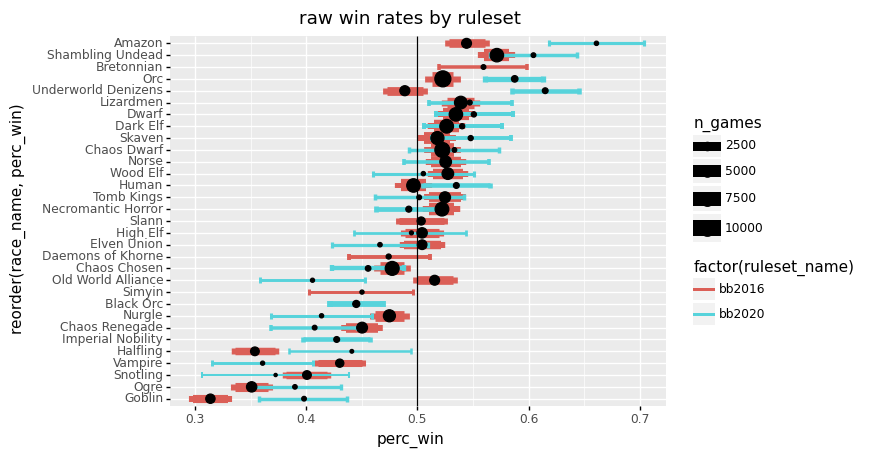

<ggplot: (-9223363297877695863)>

In [36]:

(p9.ggplot(data = res.query('n_games > 10'), mapping = p9.aes(x = 'reorder(race_name, perc_win)', y = 'perc_win', 
size = 'n_games', group = 'factor(ruleset_name)', color = 'factor(ruleset_name)'))
    + p9.geom_errorbar(p9.aes(ymin = 'lower_CI', ymax = 'upper_CI'))
    + p9.geom_point(color = 'black') 
    + p9.scale_size_area() 
    + p9.coord_flip()
    + p9.geom_hline(yintercept = 0.5)
    + p9.ggtitle("raw win rates by ruleset"))

# Conclusion based on the confidence intervals

Amazons, Orcs and Underworld denizens improved substantially. 
Halflings and goblins also improved. 
Humans a bit. Old World Alliance got substantially worse. 
Nurgle slightly worse, Vampires got worse.

Both new teams introduced in BB2020, Imperial nobility and Black orcs, are not the strongest teams around with win rates that are below average.
Slann and daemons of Khorne had no official rules from GW yet, so are not included in the Competitive division that uses BB2020 rules.


In [37]:
# aggregate by year and week number

res = (df_wins2[df_wins2['division_name'].isin(main_divisions)]
    .groupby(['week_number', 'year', 'division_name'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_games = ('race_name', "count")
    )
    .reset_index()) # this adds the group by variables (now index) as a column

res


,week_number,year,division_name,perc_win,n_games
0,1,2021.0,Blackbox,0.500820,1829
1,1,2021.0,Ranked,0.498477,985
2,1,2021.0,Regular_league,0.500000,637
3,2,2021.0,Blackbox,0.499665,1493
4,2,2021.0,Ranked,0.500543,921
...,...,...,...,...,...
196,52,2020.0,Ranked,0.496341,820
197,52,2020.0,Regular_league,0.503891,514
198,53,2020.0,Blackbox,0.499130,1725
199,53,2020.0,Ranked,0.501882,797


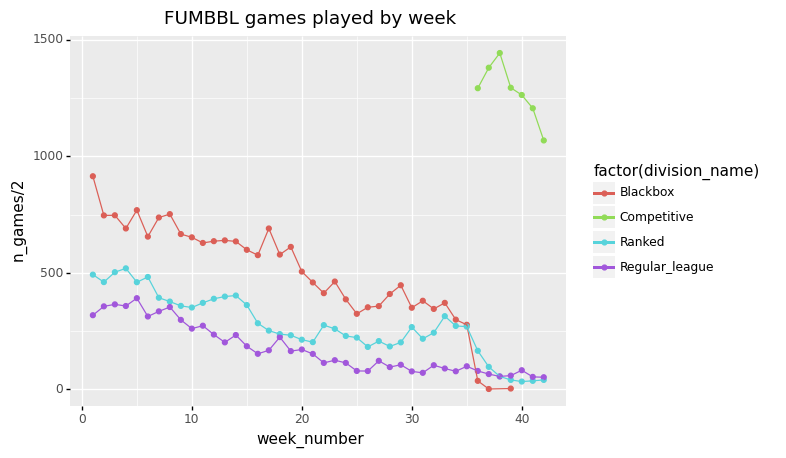

<ggplot: (8738977074510)>

In [38]:
# week 44 incomplete
(p9.ggplot(data = res.query('year > 2020 & week_number < 43'), mapping = p9.aes(x = 'week_number', y = 'n_games/2', group = 'factor(division_name)', color = 'factor(division_name)'))
    + p9.geom_point() 
    + p9.geom_line()
    #+ p9.scale_size_area() 
    + p9.ggtitle("FUMBBL games played by week"))

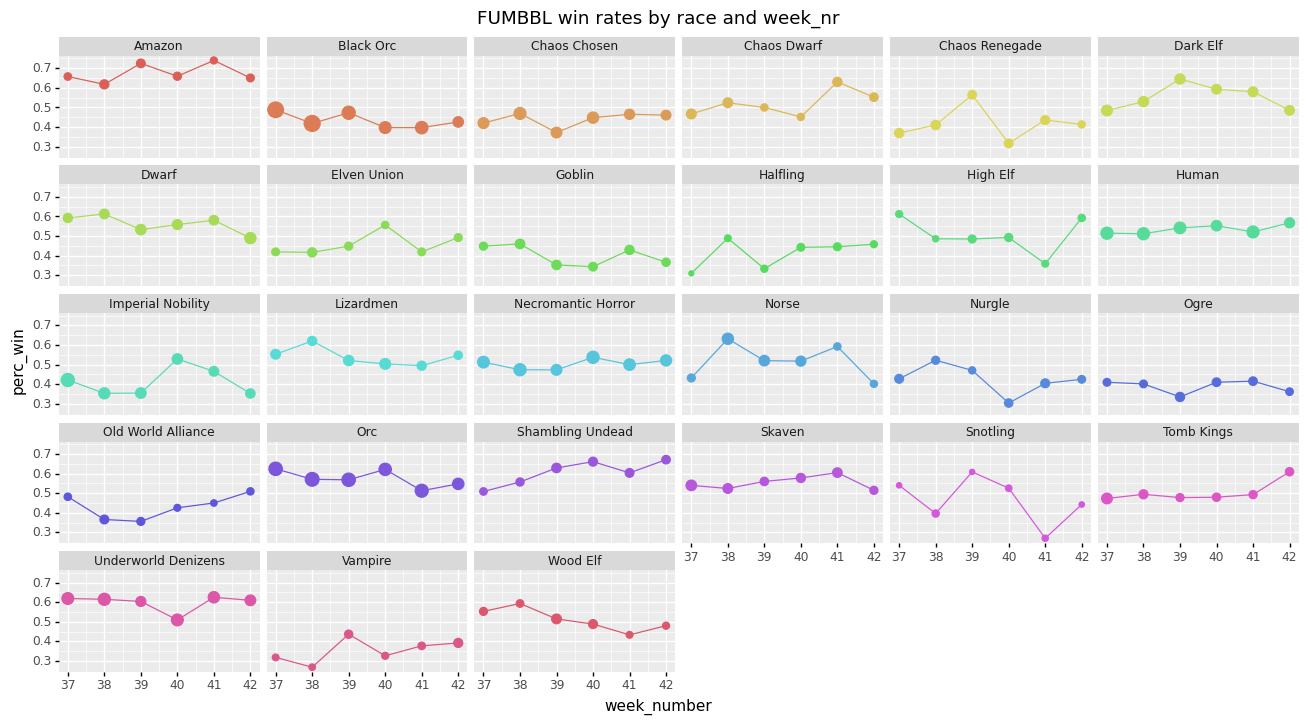

<ggplot: (8738977074959)>

In [39]:
# aggregate by year and week number

res = (df_wins2[df_wins2['ruleset'].isin(common_rulesets)]
    .groupby(['week_number', 'year', 'ruleset', 'race_name'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_games = ('race_name', "count")
    )
    .reset_index()) # this adds the group by variables (now index) as a column

res

(p9.ggplot(data = res.query('year > 2020 & week_number > 36 & ruleset == 4 & week_number < 43'), 
    mapping = p9.aes(x = 'week_number', y = 'perc_win', group = 'factor(race_name)', color = 'factor(race_name)'))
    + p9.geom_point(p9.aes(size = 'n_games')) 
    + p9.geom_line()
    + p9.scale_size_area() 
    + p9.facet_wrap('race_name')
    + p9.ggtitle("FUMBBL win rates by race and week_nr")
    + p9.theme(figure_size=(16, 8)) 
    + p9.theme(legend_position='none'))

# Concluding remarks

We can see that the new ruleset is a big succes, with the number of games played on FUMBBL almost doubled!

Starting in march 2020, online gaming activity saw a huge surge. Tabletop leagues switched to online etc. 
We can also see that the COVID-19 effect was declining in 2021, with game volume in july 2021 almost back at pre-corona levels.

As a check on our work, we compare with the plots that FUMBBL itself provides at https://fumbbl.com/p/stats

There we see that `BB2020` is labeled as `Competitive`.
We should keep in mind that we double count the games, since we for each match, we have two teams.
Even so, we still have more games that shown in the graph there, hitting the 1500 games per week mark.

So how do we map matches with rulesets onto the grouping in this plot?
It turns we need to know in which DIVISION a team plays.
And it seems that this information is not present in the team API, but is only available under coach/teams/0-1-2-3 etc.
Here the numbering indicates the temporal order in which the teams were created.


In [40]:
df_teams.query('team_id == 1047926')

,team_id,division_id,division_name,league,ruleset,roster_id,race_name,games_played
43310,1047926,10,Blackbox,0,1,65,Slann,1


# What are NAF-BB2020 matches?

They seem to be small scale, but consistent 6 week duration events? lets look up a few matches on FUMBBL.

In [41]:
#df_wins2.query('week_number == 4') # DOES NOT WORK week_number has UINT32 dtype which is not supported by query ??? wtf
#df_wins2.loc[(df_wins2['week_number'] == 4) & (df_wins2['ruleset'] == 2228)]

(df_wins2.loc[(df_wins2['ruleset'] == 2228) & (df_wins2['roster_id'] == 4956)])
    #.groupby('roster_id')
    #.count()).sort_values('roster_id', ascending = False)

,match_id,match_date,team_id,wins,division_id,division_name,league,ruleset,roster_id,race_name,games_played,roster_name,week_number,year,ruleset_name
190,4334266,2021-10-09,1.04572e+06,0.5,5,NAF,9298,2228,4956,Black Orc,4,4956_Black Orc,40,2021.0,mixed
475,4333981,2021-10-08,1.04798e+06,0.0,5,NAF,9298,2228,4956,Black Orc,4,4956_Black Orc,40,2021.0,mixed
752,4333704,2021-10-07,1.04437e+06,1.0,5,NAF,9298,2228,4956,Black Orc,4,4956_Black Orc,40,2021.0,mixed
754,4333702,2021-10-07,1.04763e+06,0.0,5,NAF,9298,2228,4956,Black Orc,4,4956_Black Orc,40,2021.0,mixed
772,4333684,2021-10-07,1.04597e+06,0.0,5,NAF,9298,2228,4956,Black Orc,3,4956_Black Orc,40,2021.0,mixed
1257,4333199,2021-10-06,1.04649e+06,1.0,5,NAF,9298,2228,4956,Black Orc,4,4956_Black Orc,40,2021.0,mixed
1362,4333094,2021-10-05,1.04543e+06,0.5,5,NAF,9298,2228,4956,Black Orc,4,4956_Black Orc,40,2021.0,mixed
3515,4330941,2021-09-27,1.04733e+06,0.5,5,NAF,9298,2228,4956,Black Orc,1,4956_Black Orc,39,2021.0,mixed
118668,4338737,2021-10-26,1.04649e+06,0.0,5,NAF,9298,2228,4956,Black Orc,4,4956_Black Orc,43,2021.0,mixed
119269,4338136,2021-10-24,1.04798e+06,0.5,5,NAF,9298,2228,4956,Black Orc,4,4956_Black Orc,42,2021.0,mixed


# NAF Tournaments: What is with ruleset 2228

match 4274272 is within a tournament called SteelBowl 2021 [EU]
The tournament has start /end dates 24 jan 2021. The match was at 29 jan.

The match was a league division game, the team played 6 games in jan/feb/march.
The League is called Online NAF tournaments.
ACtually this is a group 9298 that contains tournaments.
The group uses ruleset 2228.

# Rulesets can be overwritten 

Ruleset 2228 appears to be BB2020 + slann + khorne, which the NAF prefers over the GW BB2020 ruleset.
From the roster ids, we can see that only from oktober 2021, the NAF switched to BB2020 teams.

# Popularity of the rosters

By plotting the roster use over time, we should be able to get a nice view of both the popularity of the races, AND the introduction of BB2020.

In [42]:
common_rosters = (df_wins2
    .groupby('roster_name')
    .agg( n_games = ('ruleset', 'count')
    )
    .query('n_games > 800')
    .reset_index()
)['roster_name']

common_rosters

0       1720_Daemons of Khorne
1              1721_Bretonnian
2                    41_Amazon
3              42_Chaos Chosen
4               43_Chaos Dwarf
5                  44_Dark Elf
6                     45_Dwarf
7               46_Elven Union
8      4789_Old World Alliance
9                    47_Goblin
10                 48_Halfling
11              4956_Black Orc
12           4957_Chaos Chosen
13               4959_Dark Elf
14                  4960_Dwarf
15                  4964_Human
16      4965_Imperial Nobility
17              4966_Lizardmen
18     4969_Necromantic Horror
19                    4974_Orc
20       4975_Shambling Undead
21                 4976_Skaven
22    4978_Underworld Denizens
23               4991_Snotling
24                 49_High Elf
25                    50_Human
26                  5144_Norse
27               51_Tomb Kings
28                52_Lizardmen
29       53_Necromantic Horror
30                    54_Norse
31                   55_Nurgle
32      

In [43]:
# aggregate by year and week number
res = (df_wins2[df_wins2['roster_name'].isin(common_rosters)]
    .groupby(['week_number', 'division_name', 'year', 'roster_name'])
    .agg(        
        #perc_win = ('wins', "mean"),
        n_games = ('race_name', "count")
    )
    .reset_index()) # this adds the group by variables (now index) as a column

res

,week_number,division_name,year,roster_name,n_games
0,1,Blackbox,2021.0,41_Amazon,52
1,1,Blackbox,2021.0,42_Chaos Chosen,115
2,1,Blackbox,2021.0,43_Chaos Dwarf,118
3,1,Blackbox,2021.0,44_Dark Elf,98
4,1,Blackbox,2021.0,45_Dwarf,175
...,...,...,...,...,...
7712,53,Regular_league,2020.0,66_Underworld Denizens,4
7713,53,Regular_league,2020.0,72_Simyin,8
7714,53,Secret League,2020.0,44_Dark Elf,1
7715,53,Secret League,2020.0,4991_Snotling,1


/home/gertjan/venvs/requests_env/lib/python3.6/site-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


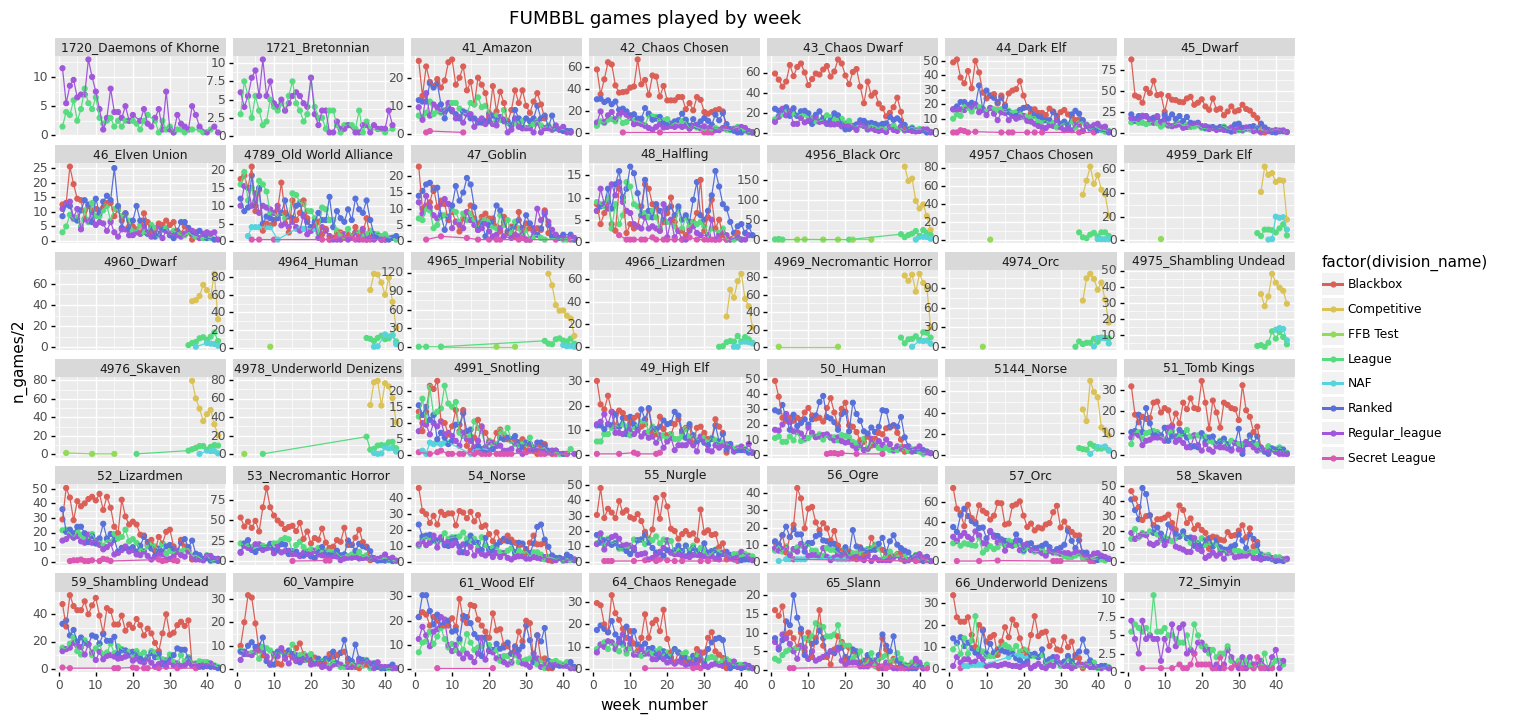

<ggplot: (-9223363297838886624)>

In [44]:

(p9.ggplot(data = res.query('year > 2020'), mapping = p9.aes(x = 'week_number', y = 'n_games/2', group = 'factor(division_name)', color = 'factor(division_name)'))
    + p9.geom_point() 
    + p9.geom_line()
    #+ p9.scale_size_area() 
    + p9.facet_wrap('roster_name', scales = 'free_y')
    #+ p9.theme(legend_position='none')
    + p9.theme(figure_size=(16, 8)) 
    + p9.ggtitle("FUMBBL games played by week"))

In [45]:
res = df_wins2.query('week_number < 30 & roster_id == 4956 & division_name == "League"')

res['team_id'] = res['team_id'].astype("int64")

res['team_id']

/home/gertjan/venvs/requests_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


25320     1033863
62892     1018681
64999     1013774
65917     1013662
67163     1013964
188866    1014276
188949    1013767
191371    1014276
Name: team_id, dtype: int64

In [46]:
# aggregate by year and week number

res = (df_wins2
    .groupby(['division_name', 'week_number', 'year'])
    .agg(        
        #perc_win = ('wins', "mean"),
        n_games = ('race_name', "count")
    )
    .reset_index()) # this adds the group by variables (now index) as a column

res['n_games'] = res['n_games']/2

res

,division_name,week_number,year,n_games
0,Blackbox,1,2021.0,914.5
1,Blackbox,2,2021.0,746.5
2,Blackbox,3,2021.0,747.0
3,Blackbox,4,2021.0,690.5
4,Blackbox,5,2021.0,769.0
...,...,...,...,...
521,Stunty Leeg,49,2020.0,33.0
522,Stunty Leeg,50,2020.0,49.0
523,Stunty Leeg,51,2020.0,27.0
524,Stunty Leeg,52,2020.0,20.0


In [47]:
df_matches_final['match_id'].max()

4339204

# Reproduce the FUMBBL 30-weeks plot

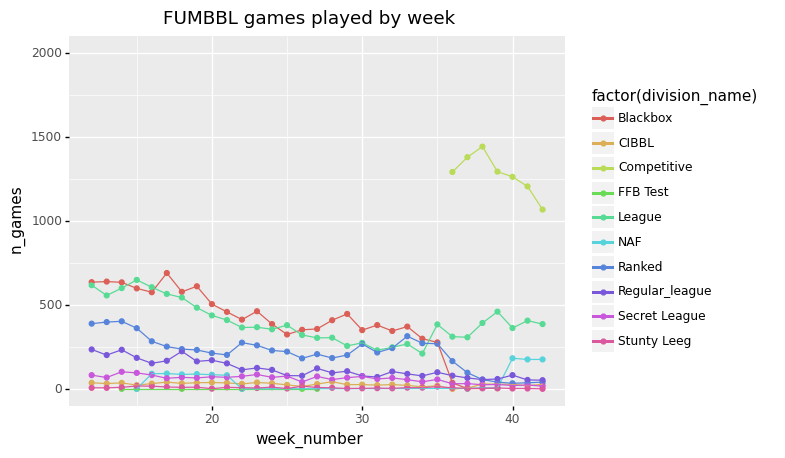

<ggplot: (-9223363297892769925)>

In [48]:
(p9.ggplot(data = res.query('year > 2020 & week_number < 43 & week_number > 11'), mapping = p9.aes(x = 'week_number', y = 'n_games', 
group = 'factor(division_name)', color = 'factor(division_name)'))
    + p9.geom_point() 
    + p9.geom_line()
    + p9.expand_limits(y=[0,2000])
    + p9.ggtitle("FUMBBL games played by week"))

    # yes we exactly reproduce the counts from FUMBBL 30 week plot

In [49]:
# Check the league field
# aggregate by year and week number


#res.to_excel("league_numbers.xlsx")  


res = (df_wins2
    .groupby(['division_name', 'ruleset', 'league'])
    .agg(        
        #perc_win = ('wins', "mean"),
        n_games = ('race_name', "count")
    )
    .sort_values( 'n_games', ascending = False)
    .reset_index()) # this adds the group by variables (now index) as a column

res['n_games'] = res['n_games']/2

res.query('n_games > 2000')

,division_name,ruleset,league,n_games
0,Blackbox,1,0,36300.5
1,Ranked,1,0,21290.5
2,Regular_league,6,0,13194.5
3,Competitive,4,0,9457.0
4,Secret League,303,10263,5257.0
5,NAF,2228,9298,3437.5


In [50]:
df_wins2.query('ruleset == 6 & division_name == "League" and league ==0 & week_number == 3')

,match_id,match_date,team_id,wins,division_id,division_name,league,ruleset,roster_id,race_name,games_played,roster_name,week_number,year,ruleset_name


# League analyse

There are a lot of small leagues being played on FUMBBL. Reasons to play in small local leagues vary.
There are a few larger leagues, that have nation wide scale. There are two leagues that are international and have sufficient scale to analyse separately.

This is the NAF tournaments, and the Secret League.

10263 (ruleset 303, Secret League)
9298

# So final groupings
Competitive BB2020
Ranked BB2016
Black box BB2016
League ruleset 6 / league 0 (regular league)
League ruleset 2228 / league 9298 (NAF tournaments)

Checked by christer: Does this mean that the API only serves the most recent version of a ruleset, and that rulesets can be changed without requiring a new ruleset id to be created? Correct

In [51]:
# Amazon lineups
df_wins2.query('division_name == "Competitive" and race_name == "Amazon"')

,match_id,match_date,team_id,wins,division_id,division_name,league,ruleset,roster_id,race_name,games_played,roster_name,week_number,year,ruleset_name
4,4334452,2021-10-10,1.04909e+06,0.0,2,Competitive,0,4,5141,Amazon,1,5141_Amazon,40,2021.0,bb2020
103,4334353,2021-10-10,1.04923e+06,0.5,2,Competitive,0,4,5141,Amazon,5,5141_Amazon,40,2021.0,bb2020
152,4334304,2021-10-09,1.04766e+06,1.0,2,Competitive,0,4,5141,Amazon,3,5141_Amazon,40,2021.0,bb2020
161,4334295,2021-10-09,1.04898e+06,1.0,2,Competitive,0,4,5141,Amazon,10,5141_Amazon,40,2021.0,bb2020
170,4334286,2021-10-09,1.04734e+06,0.5,2,Competitive,0,4,5141,Amazon,4,5141_Amazon,40,2021.0,bb2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245788,4334566,2021-10-10,1.04968e+06,1.0,2,Competitive,0,4,5141,Amazon,4,5141_Amazon,40,2021.0,bb2020
245813,4334541,2021-10-10,1.04968e+06,0.0,2,Competitive,0,4,5141,Amazon,2,5141_Amazon,40,2021.0,bb2020
245842,4334512,2021-10-10,1.04968e+06,1.0,2,Competitive,0,4,5141,Amazon,4,5141_Amazon,40,2021.0,bb2020
245877,4334477,2021-10-10,1.04898e+06,0.5,2,Competitive,0,4,5141,Amazon,10,5141_Amazon,40,2021.0,bb2020
